<a href="https://colab.research.google.com/github/rrfsantos/Desafios-NLP/blob/main/Image_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!python -m pip install pdf2image
!sudo apt-get install poppler-utils
!python -m pip install pillow

Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.62.0-2ubuntu2.12).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [60]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import glob
from pdf2image import convert_from_path
from PIL import Image

In [61]:
from google.colab import drive
drive.mount('/content/drive')

import os
workdir_path = '/content/drive/My Drive/BNDES/Banco de Servicos/'
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# Selecionar pdfs de contratos
pdf_path = glob.glob('contratos/*')
pdf_contratos = []
for i in range(len(pdf_path)):
  if 'contrato' in (os.path.basename(pdf_path[i])).lower():
    pdf_contratos.append(pdf_path[i])

In [63]:
# Tranformação dos pdfs de contratos em imagems
for i in range(len(pdf_contratos)):
    pages = convert_from_path(pdf_contratos[i], single_file=True)
    for j in range(len(pages)):
      page = pages[j]
      page.save('imagens_cluster/' + os.path.basename(pdf_contratos[i]).split('.')[0] + '_{}.png'.format(j), 'PNG')

In [64]:
# this list holds all the image filename
imagem_contratos = glob.glob('imagens_cluster/*')

model = VGG16()

model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [65]:
data = {}
p = r'/Model Development/imagens_features.pkl'

# lop through each image in the dataset
for imagem in imagem_contratos:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(imagem,model)
        data[imagem] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
          
 
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape
(210, 1, 4096)

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape
(210, 4096)

(210, 4096)

In [66]:
pca = PCA(n_components=100)
pca.fit(feat)
x = pca.transform(feat)

In [79]:
kmeans = KMeans(n_clusters=4, random_state=123, verbose=1)
kmeans.fit(x)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 96800.336
start iteration
done sorting
end inner loop
Iteration 1, inertia 89816.484
start iteration
done sorting
end inner loop
Iteration 2, inertia 88217.234
start iteration
done sorting
end inner loop
Iteration 3, inertia 87897.95
start iteration
done sorting
end inner loop
Iteration 4, inertia 87866.67
start iteration
done sorting
end inner loop
Iteration 5, inertia 87866.67
center shift 0.000000e+00 within tolerance 9.297471e-04
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 104436.29
start iteration
done sorting
end inner loop
Iteration 1, inertia 97139.6
start iteration
done sorting
end inner loop
Iteration 2, inertia 92156.58
start iteration
done sorting
end inner loop
Iteration 3, inertia 87997.016
start iteration
done sorting
end inner loop
Iteration 4, inertia 87330.164
start iteration
done sorting
end inner loop
Iteration 5, inertia 87330.164
ce

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=1)

In [80]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

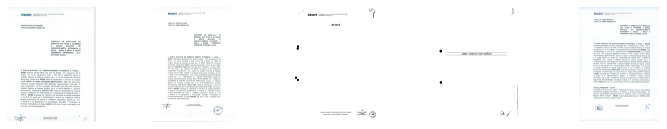

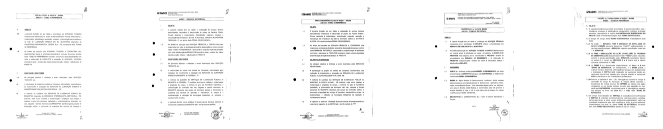

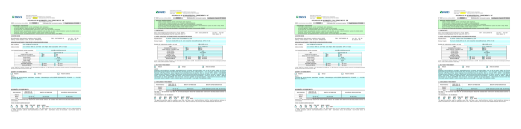

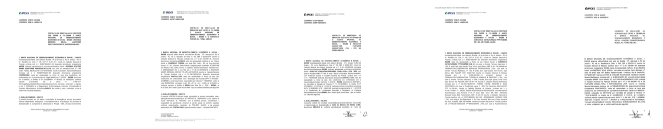

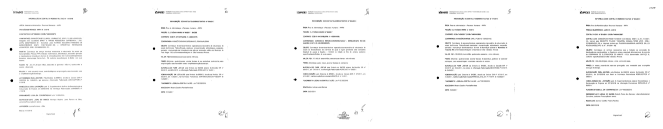

In [81]:
# function that lets you view a cluster (based on identifier)        
for i in range(len(groups)):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[i]
    # only allow up to 5 images to be shown at a time
    first_images = files[:5]
    # plot each image in the cluster
    for index, file in enumerate(first_images):
        #print(f'Group {i}')
        plt.subplot(10,10,index+1);
        img = plt.imread(file)
        img = np.array(img)
        plt.imshow(img,cmap='gray')
        plt.axis('off'); 

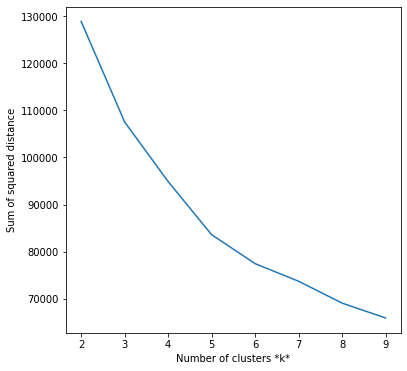

In [75]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(2, 10))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');